In [1]:
"""Cell for initializing and opening the database"""

import sqlite3

import numpy as np
import matplotlib.pyplot as plt
#matplotlibinline

db = sqlite3.connect("file:lol_match_data.db?mode=ro", uri=True)
cur = db.cursor()

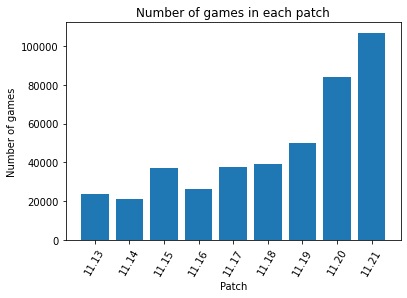

In [2]:
# Lets get a list of all how many games there are in each patch
patches = ["11.12", "11.13", "11.14", "11.15", "11.16", "11.17", "11.18", "11.19", "11.20", "11.21", "11.22"]
game_count = []
for patch in patches:
    cur.execute("SELECT COUNT(*) FROM raw WHERE patch LIKE ?", (patch + "%",))
    game_count.append(int(cur.fetchone()[0]) / 10)

plt.bar(patches[1:-1], game_count[1:-1])
plt.xticks(rotation=60)
plt.title("Number of games in each patch")
plt.ylabel("Number of games")
plt.xlabel("Patch")
plt.show()

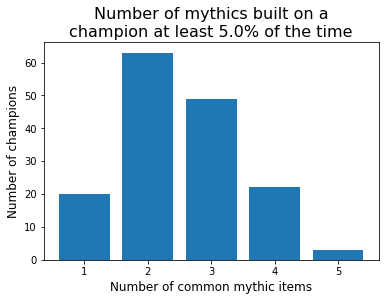

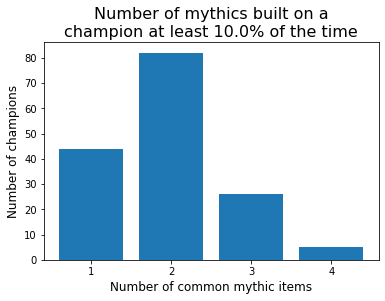

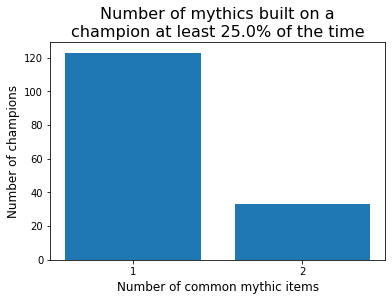

In [3]:
# Lets see how many champions have how many choices for an item

def champion_and_popular_mythics():
    
    query = """
    WITH common AS (SELECT a.*
        , CAST(a.totalGames AS REAL) / b.totalGames AS pickRate
    FROM aggregate AS a
    JOIN (SELECT champion
            , mythic
            , totalGames
        FROM aggregate
        WHERE mythic = "All"
    ) AS b
    ON b.champion = a.champion
    WHERE
        a.mythic NOT IN ("All", "None") AND pickrate >= ?
    )
    
    SELECT nrMythics, COUNT(champion) AS nrChampions
    FROM (
        SELECT champion, COUNT(mythic) AS nrMythics
        FROM common
        GROUP BY champion
    ) GROUP BY nrMythics"""
    
    for lower_bound in (0.05, 0.10, 0.25):
        cur.execute(query, (lower_bound,))
        
        nrMythics, nrChampions = zip(*cur.fetchall())
        
        plt.bar(nrMythics, nrChampions)
        plt.xlabel("Number of common mythic items", fontsize = 12)
        plt.ylabel("Number of champions", fontsize = 12)
        plt.xticks(range(min(nrMythics), max(nrMythics) + 1))
        plt.title(f"Number of mythics built on a\nchampion at least {lower_bound*100}% of the time", fontsize=16)
        plt.show()

champion_and_popular_mythics()

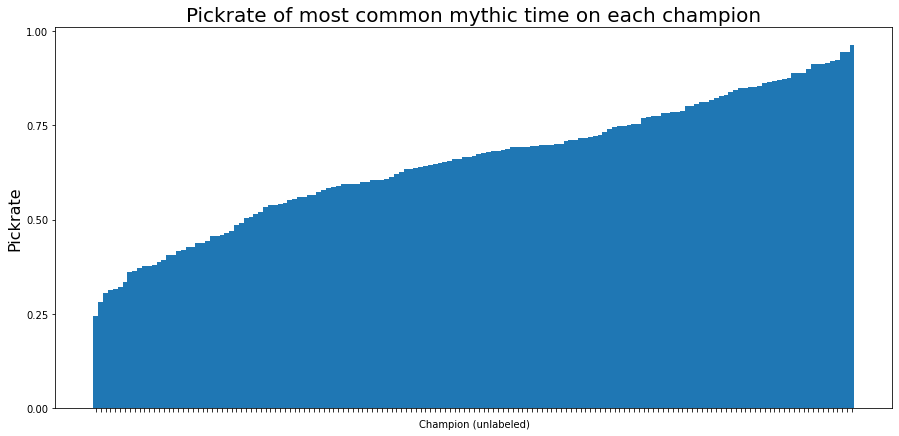

In [4]:
# Lets see how popular the most popular mythic is on a champion
def popularity_of_most_popular_mythic():
    # Reusing this to get the pick rate for all entries in the aggregate
    query = """
    WITH common AS (SELECT a.*
        , CAST(a.totalGames AS REAL) / b.totalGames AS pickRate
    FROM aggregate AS a
    JOIN (SELECT champion
            , mythic
            , totalGames
        FROM aggregate
        WHERE mythic = "All"
    ) AS b
    ON b.champion = a.champion
    WHERE
        a.mythic NOT IN ("All", "None")
    )
    
    SELECT champion, MAX(pickrate) FROM common GROUP BY champion ORDER BY pickrate
    """
    
    cur.execute(query)
    
    champion, pickrate = zip(*cur.fetchall())
    plt.figure(figsize=(15, 7))
    plt.bar(champion, pickrate, width=1.0)
    plt.yticks([0.0, 0.25, 0.50, 0.75, 1.0])
    plt.title("Pickrate of most common mythic time on each champion", fontsize=20)
    plt.ylabel("Pickrate", fontsize=16)
    plt.xlabel("Champion (unlabeled)")
    
    ax = plt.gca()
    
    ax.xaxis.set_ticklabels([])
    #plt.tight_layout()
    plt.show()

popularity_of_most_popular_mythic()
# This graph shows that the most popular mythic is VERY popular on most of the champions.
# We should look at the actual numbers to compare with Riot's goal.

In [5]:
# In https://www.leagueoflegends.com/en-us/news/dev/quick-gameplay-thoughts-feb-26/,
# Riot claims their goal is no one builds the same item over 75% of the time.

def riots_claim(bound):
    query = """
    WITH common AS (SELECT a.*
        , CAST(a.totalGames AS REAL) / b.totalGames AS pickRate
    FROM aggregate AS a
    JOIN (SELECT champion
            , mythic
            , totalGames
        FROM aggregate
        WHERE mythic = "All"
    ) AS b
    ON b.champion = a.champion
    WHERE
        a.mythic NOT IN ("All", "None")
    )
    
    SELECT DISTINCT champion FROM common WHERE pickRate >= ?
    """
    cur.execute(query, (bound,))
    dat = cur.fetchall()
    print(f"{len(dat)} out of 157 champions ({len(dat) / 157 * 100:.2f}%) build a specific mythic {bound * 100:.0f}% of the time or more.")

riots_claim(.75)
riots_claim(.50)
# Yikes!

46 out of 157 champions (29.30%) build a specific mythic 75% of the time or more.
126 out of 157 champions (80.25%) build a specific mythic 50% of the time or more.


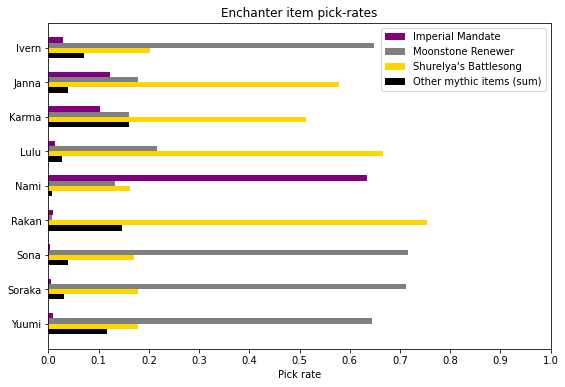

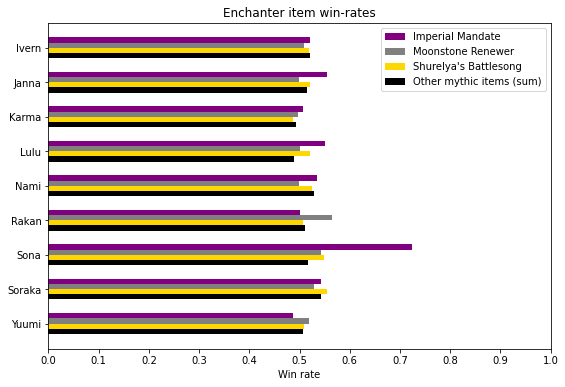

In [6]:
# Lets go in depth into enchanter analysis. We will look at winrates and pickrates
# For the enchanter mythics on enchanters.

def enchanter_analysis():
    # SQL is "FUN"
    query = """
WITH common AS (SELECT a.*
	, CAST(a.totalGames AS REAL) / b.totalGames AS pickRate
FROM aggregate AS a
JOIN (SELECT champion
			, mythic
			, totalGames
		FROM aggregate
		WHERE mythic = "All"
	) AS b
ON b.champion = a.champion
WHERE
	a.mythic NOT IN ("All", "None") AND pickrate >= 0.00
)

SELECT a.champion
	, a.pickRate AS MandatePR
	, b.pickRate AS MoonstonePR
	, c.pickRate AS BattlesongPR
	, d.averagePickrate AS OtherPR
	, CAST(a.wins AS REAL) / a.totalGames AS MandateWR
	, CAST(b.wins AS REAL) / b.totalGames AS MoonstoneWR
	, CAST(c.wins AS REAL) / c.totalGames AS BattlesongWR
	, d.averageWinrate AS OtherWR
FROM (SELECT * FROM common WHERE mythic = "Imperial Mandate")  AS a
JOIN (SELECT * FROM common WHERE mythic = "Moonstone Renewer") AS b
ON a.champion = b.champion
JOIN (SELECT * FROM common WHERE mythic = "Shurelya's Battlesong") AS c
ON a.champion = c.champion
JOIN (SELECT *
		, SUM(CAST(a.wins AS REAL)) / SUM(CAST(a.totalGames AS REAL)) AS averageWinrate 
		, SUM(CAST(a.totalGames AS REAL)) / CAST(b.totalGames AS REAL) AS averagePickrate
	FROM aggregate AS a
	JOIN (SELECT * FROM aggregate WHERE mythic = "All") AS b
	ON a.champion = b.champion
	WHERE a.mythic NOT IN ("All", "None", "Imperial Mandate", "Moonstone Renewer", "Shurelya's Battlesong")
	GROUP BY a.champion
) AS d
ON a.champion = d.champion
WHERE (a.pickRate + b.pickRate + c.pickRate) > 0.75 ORDER BY a.champion DESC
"""
    cur.execute(query)
    
    champ, imPr, mrPr, sbPr, oPr, imWr, mrWr, sbWr, oWr = zip(*cur.fetchall())
    
    # Shamelessly adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
    x = np.arange(len(champ))
    width = .15

    
    fig, ax = plt.subplots()
    rects1 = ax.barh(x + 0.225, imPr, width, label="Imperial Mandate", color="purple")
    rects2 = ax.barh(x + 0.075, mrPr, width, label="Moonstone Renewer", color="grey")
    rects3 = ax.barh(x - 0.075, sbPr, width, label="Shurelya's Battlesong", color="gold")
    rects4 = ax.barh(x - 0.225, oPr,  width, label="Other mythic items (sum)", color="black")

    
    ax.set_xlabel("Pick rate")
    ax.set_title("Enchanter item pick-rates")
    ax.set_yticks(x, champ)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    
    fig.set_figheight(6)
    fig.set_figwidth(9)
    
    ax.legend()
    
    plt.show()

    # winrates
    fig, ax = plt.subplots()
    rects1 = ax.barh(x + 0.225, imWr, width, label="Imperial Mandate", color="purple")
    rects2 = ax.barh(x + 0.075, mrWr, width, label="Moonstone Renewer", color="grey")
    rects3 = ax.barh(x - 0.075, sbWr, width, label="Shurelya's Battlesong", color="gold")
    rects4 = ax.barh(x - 0.225, oWr,  width, label="Other mythic items (sum)", color="black")

    ax.set_xlabel("Win rate")
    ax.set_title("Enchanter item win-rates")
    ax.set_yticks(x, champ)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    
    fig.set_figheight(6)
    fig.set_figwidth(9)
    
    ax.legend()

    plt.show()
    
    
enchanter_analysis()